In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)

val_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
val_dataloader = DataLoader(dataset=val_dataset, batch_size=8, shuffle=False)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
def training_process_plot(train_loss_arr, val_loss_arr):
    plt.figure(figsize=(10, 8))
    plt.plot(train_loss_arr, label='Train')
    plt.plot(val_loss_arr, label='Validation')
    plt.legend()

In [6]:
def epochs_output_visualizer(epochs_output):
    for epoch, (img, output) in enumerate(epochs_output):
        img, output = img.reshape(-1, 28, 28).unsqueeze(1), output.reshape(-1, 28, 28).unsqueeze(1)

        plt.figure(figsize=(10, 5))
        plt.title(f'Epoch {epoch}')
        plt.axis('off')
        plt.imshow(torchvision.utils.make_grid(torch.cat((img, output)), nrow=8).cpu().permute(1, 2, 0));
        plt.show()

In [13]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device):
    epochs_output = []

    train_loss_arr, val_loss_arr = [], []
    for epoch in range(num_epochs):
        train_loss, val_loss = .0, .0

        model.train()
        for img, _ in train_dataloader:
            img = img.to(device)

            output = model(img)
            loss = criterion(output.reshape(-1, 28*28), img.reshape(-1, 28*28))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
        
        model.eval()
        with torch.no_grad():
            for idx, (img, _) in enumerate(val_dataloader):
                img = img.to(device)
                output = model(img)
                loss = criterion(output.reshape(-1, 28*28), img.reshape(-1, 28*28))
                val_loss += loss.item()

                if idx == 0:
                    epochs_output.append((img, output))

        train_loss_arr.append(train_loss/len(train_dataloader))
        val_loss_arr.append(val_loss/len(val_dataloader))

        print(f'Epoch: {"{:2d}".format(epoch)} -> \t Train Loss: {"%.10f"%train_loss_arr[-1]} \t Validation Loss: {"%.10f"%val_loss_arr[-1]}')

    return train_loss_arr, val_loss_arr, epochs_output

# Linear Autoencoder

In [14]:
class LinearAutoencoder(nn.Module):
    def __init__(self):
        super(LinearAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
        )
    
    def forward(self, x):
        return self.decoder(self.encoder(x.reshape(-1, 28*28)))

In [20]:
model = LinearAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [21]:
train_loss_arr, val_loss_arr, epochs_output = train(model, train_dataloader, val_dataloader, criterion, optimizer, 10, device)

Epoch:  0 -> 	 Train Loss: 0.0571521850 	 Validation Loss: 0.0471454092
Epoch:  1 -> 	 Train Loss: 0.0443557227 	 Validation Loss: 0.0416510483
Epoch:  2 -> 	 Train Loss: 0.0378834855 	 Validation Loss: 0.0344756012
Epoch:  3 -> 	 Train Loss: 0.0334614152 	 Validation Loss: 0.0321010325
Epoch:  4 -> 	 Train Loss: 0.0316403656 	 Validation Loss: 0.0311042876
Epoch:  5 -> 	 Train Loss: 0.0302032500 	 Validation Loss: 0.0295863439
Epoch:  6 -> 	 Train Loss: 0.0288695830 	 Validation Loss: 0.0285286367
Epoch:  7 -> 	 Train Loss: 0.0280968302 	 Validation Loss: 0.0278587709
Epoch:  8 -> 	 Train Loss: 0.0275498094 	 Validation Loss: 0.0273565513
Epoch:  9 -> 	 Train Loss: 0.0271495411 	 Validation Loss: 0.0273389072


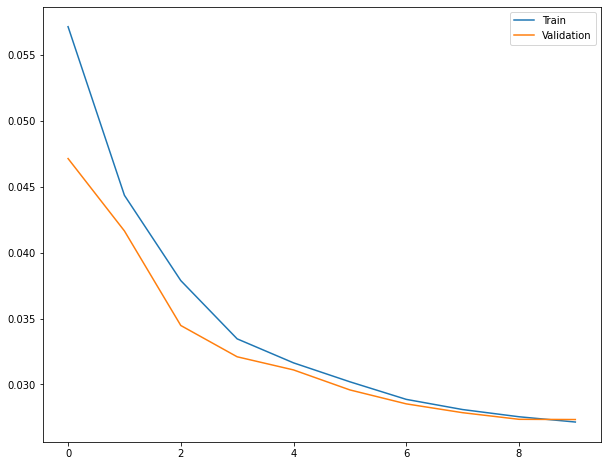

In [22]:
training_process_plot(train_loss_arr, val_loss_arr)

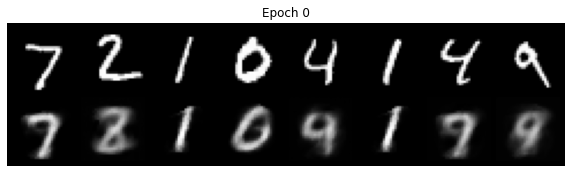

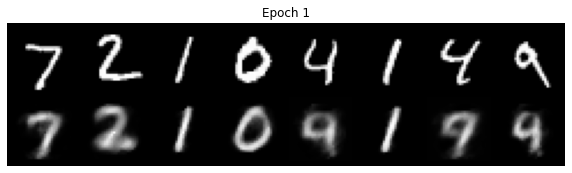

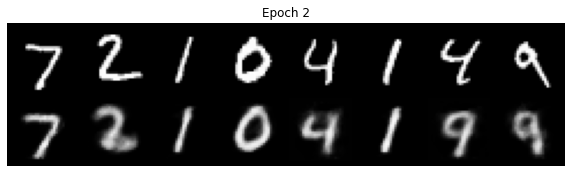

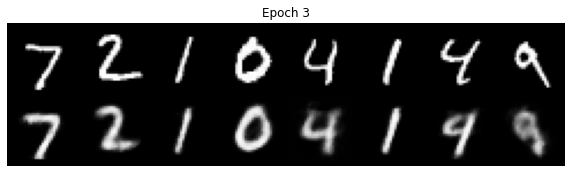

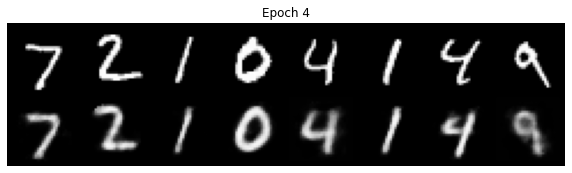

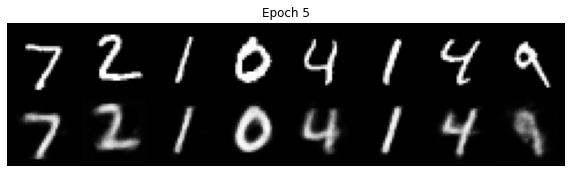

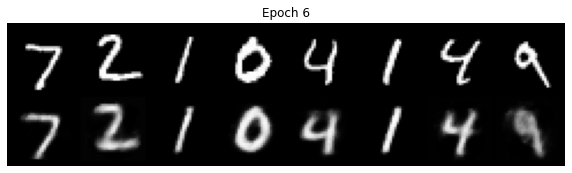

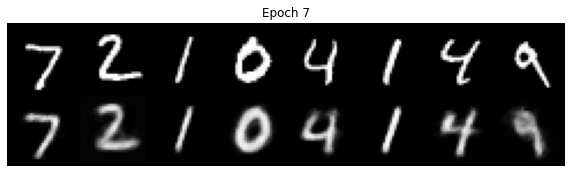

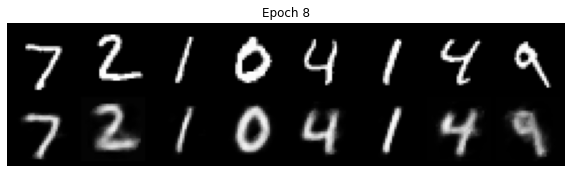

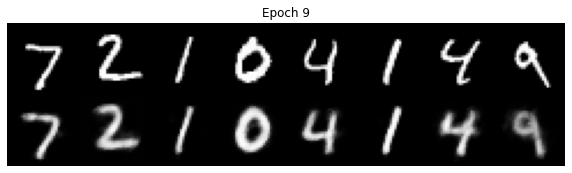

In [23]:
epochs_output_visualizer(epochs_output)

# CNN Autoencoder

In [24]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            # Input: B, 1, 28, 28
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # B, 16, 14, 14
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # B, 32, 7, 7
            nn.ReLU(),
            nn.Conv2d(32, 64, 7), # B, 64, 1, 1
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.decoder(self.encoder(x.reshape(-1, 1, 28, 28)))

In [26]:
model = CNNAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [27]:
train_loss_arr, val_loss_arr, epochs_output = train(model, train_dataloader, val_dataloader, criterion, optimizer, 10, device)

Epoch:  0 -> 	 Train Loss: 0.0368838873 	 Validation Loss: 0.0127029371
Epoch:  1 -> 	 Train Loss: 0.0096329513 	 Validation Loss: 0.0073460669
Epoch:  2 -> 	 Train Loss: 0.0066414951 	 Validation Loss: 0.0057880611
Epoch:  3 -> 	 Train Loss: 0.0054054112 	 Validation Loss: 0.0048691522
Epoch:  4 -> 	 Train Loss: 0.0047482912 	 Validation Loss: 0.0043446000
Epoch:  5 -> 	 Train Loss: 0.0043300509 	 Validation Loss: 0.0041168107
Epoch:  6 -> 	 Train Loss: 0.0040531137 	 Validation Loss: 0.0039219836
Epoch:  7 -> 	 Train Loss: 0.0038764284 	 Validation Loss: 0.0037405105
Epoch:  8 -> 	 Train Loss: 0.0037827418 	 Validation Loss: 0.0035840312
Epoch:  9 -> 	 Train Loss: 0.0036782005 	 Validation Loss: 0.0035232806


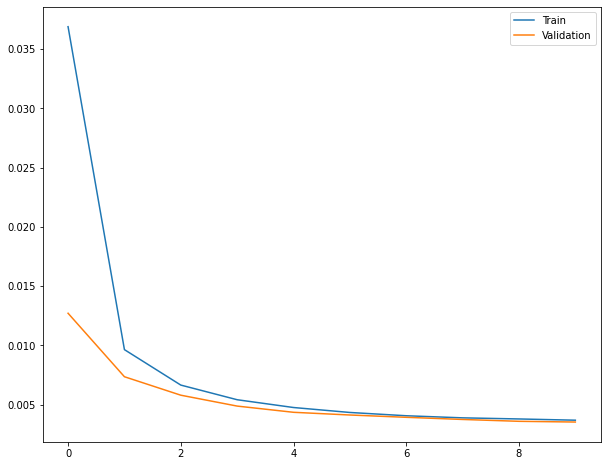

In [28]:
training_process_plot(train_loss_arr, val_loss_arr)

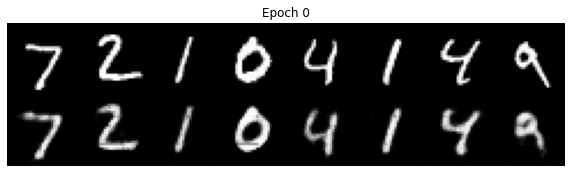

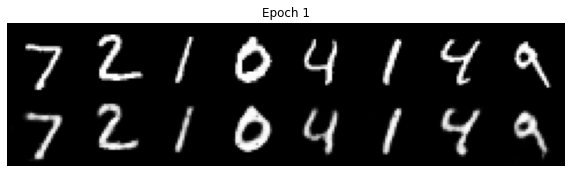

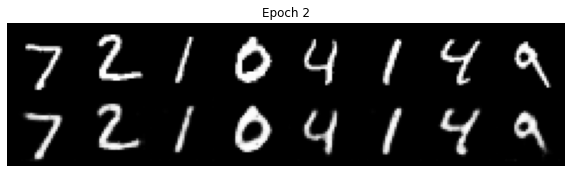

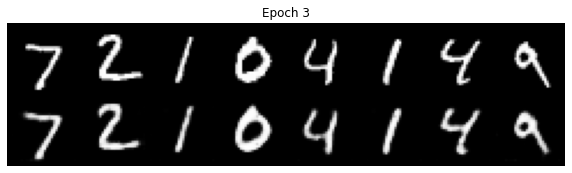

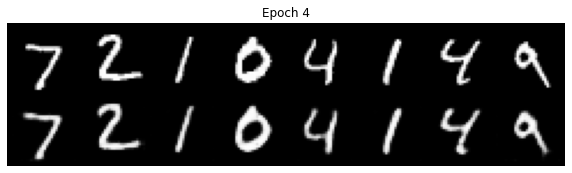

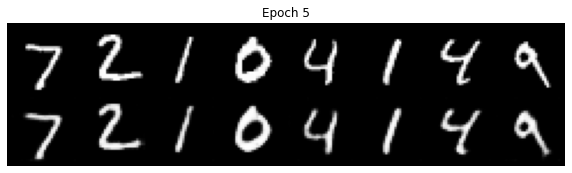

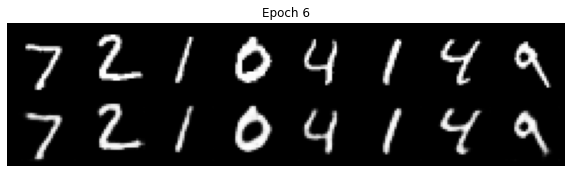

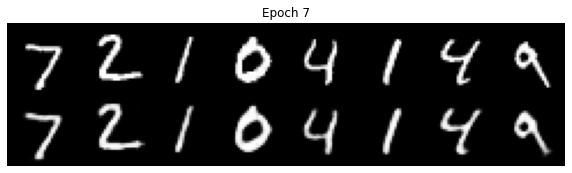

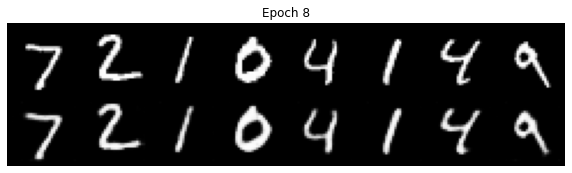

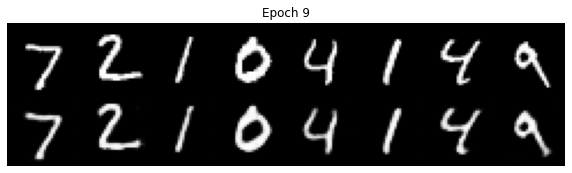

In [29]:
epochs_output_visualizer(epochs_output)